# Learn to estimate parameters of a single-qubit Hamiltonian
**Performing system identification with Boulder Opal**

In this tutorial, you will use Boulder Opal to obtain estimates of parameters present in a single-qubit Hamiltonian, using data from a simulated experiment.

You will achieve this by running an optimization where you define your model of the system as a graph, and minimize the difference between the data from the simulated experiment and the predictions from your model.
This allows you to find estimates of the parameters that most closely reproduce the simulated experimental data.
After that, you will analyze the precision of your parameter estimates and compare them with the correct values.

## Estimate parameters of a single-qubit Hamiltonian

Your task will be to estimate the values of the parameters $\Omega_x$, $\Omega_y$, and $\Omega_z$ from the following single-qubit Hamiltonian:

$$ H = \frac{1}{2} \left( \Omega_x \sigma_x + \Omega_y \sigma_y + \Omega_z \sigma_z \right), $$

where the Pauli matrices are

$$ \sigma_x = \left( \begin{array}{cc} 0 & 1 \\ 1 & 0 \end{array} \right), \, \sigma_y = \left( \begin{array}{cc} 0 & -i \\ i & 0 \end{array} \right), \, \sigma_z = \left( \begin{array}{cc} 1 & 0 \\ 0 & -1 \end{array} \right). $$

To perform this estimation, you will not have access to the Hamiltonian directly, but only to the results of the experiment.
In each experiment setup, you can choose the initial state, let it evolve for a time that you select, and then measure an observable.
As the free evolution of the state depends on the Hamiltonian, measuring an observable for different time intervals gives you information about the parameters that you want to determine.



To complete the system identification, you will create a graph that models the system whose parameters you want to estimate are optimizable variables.
Next, you will run an optimization that minimizes the difference between the predictions of your model and the experimental data.
With this, the optimizer will obtain estimates of the parameters that match the experimental data as closely as possible.

To discover the model of a real hardware system, you would attempt to characterize it using measured experimental data.
However, for the purposes of this tutorial, you will use the `run_experiments` function below to simulate the system that you are going to analyze.
You can think of it as a black-box function that interacts with the qubit that you want to characterize.

To use it, you just need to provide a batch of initial states (`initial_states`), observables (`observables`), and wait times (`wait_times`) for the experimental setups that you want to run.
The function will then simulate all the experiments in the batch by preparing the qubit in the initial state, letting it evolve for a wait time, and then measuring the observable that you requested.
The values returned are the expectation values for the observable, with an error added to represent the uncertainty inherent to calculating an observable from a finite set of measurements.
More specifically, the observables will be Pauli matrices, and the associated errors in the measured expectation values will have Gaussian probability distributions with a standard deviation of 0.02.

In [1]:
# Correct values of the parameters that you want to determine.
# The `run_experiments` function will use them to produce simulated experimental results.
actual_parameters = [3.54e5, 7.91e5, -5e5]  # Hz
parameter_names = ["Ω_x", "Ω_y", "Ω_z"]


def run_experiments(initial_states, observables, wait_times):
    """
    A black-box function representing a quantum system whose parameters
    you want to determine.

    Parameters
    ----------
    initial_states : np.ndarray
        An array containing the initial states of each experiment setup.
        Its shape must be ``(N, 2, 1)``, where ``N`` is the number of
        experiment setups
    observables : np.ndarray
        An array containing the observables that you want to measure at
        the end of each experiment setup. Its shape must be ``(N, 2, 2)``,
        where ``N`` is the number of experiment setups.
    wait_times : np.ndarray
        The list of times when the experiment ends. Its shape must be
        ``(T,)``, where ``T`` is the number of points in time where the
        experiment ends.

    Returns
    -------
    np.ndarray
        A batch of simulated experimental results corresponding to the
        setups and times that you provided. It will have shape ``(N, T)``,
        where ``N`` is the number of experimental setups and ``T`` is the
        number of wait times.
    """

    alpha_x, alpha_y, alpha_z = actual_parameters

    graph = bo.Graph()

    hamiltonian = graph.constant_pwc(
        constant=(
            alpha_x * graph.pauli_matrix("X")
            + alpha_y * graph.pauli_matrix("Y")
            + alpha_z * graph.pauli_matrix("Z")
        )
        * 0.5,
        duration=np.max(wait_times),
    )
    unitary = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=wait_times
    )
    final_states = unitary @ initial_states[:, None]

    expectation_values = graph.real(
        graph.expectation_value(final_states[..., 0], observables[:, None])
    )

    errors = graph.random.normal(
        shape=expectation_values.shape, mean=0, standard_deviation=0.02
    )
    measurement_results = expectation_values + errors
    measurement_results.name = "measurement_results"

    result = bo.execute_graph(graph, "measurement_results")

    return result["output"]["measurement_results"]["value"]

### 1. Import libraries

Before doing any calculation with Boulder Opal, you need to import the necessary packages.
To learn more about installing Boulder Opal, see the [Get started](https://docs.q-ctrl.com/boulder-opal/get-started) guide. 

In [2]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer
import boulderopal as bo

# Apply Q-CTRL style to plots created in pyplot.
plt.style.use(qctrlvisualizer.get_qctrl_style())

### 2. Obtain data from the simulated experiment

To perform system identification, you want to compare the model predictions with the data that you obtain from the `run_experiments` function provided at the beginning of this tutorial.
Use a set of initial states, observables, and wait times that correspond to the experiments that you'd be running.

Specifically, you will be using three types of experiment setups:
1. Prepare the system at state $| z+ \rangle$ and measure $\sigma_x$ after a period of free evolution.
2. Prepare the system at state $| x+ \rangle$ and measure $\sigma_y$ after a period of free evolution.
3. Prepare the system at state $| y+ \rangle$ and measure $\sigma_z$ after a period of free evolution.

For each kind of experiment, the system is left to evolve for 40 values of time.

In [3]:
# Define initial states of the experiments.
state_zp = np.array([[1], [0]])  # |z+⟩, also known as |0⟩
state_xp = np.array([[1], [1]]) / np.sqrt(2)  # |x+⟩, also known as |+⟩
state_yp = np.array([[1], [1j]]) / np.sqrt(2)  # |y+⟩
initial_states = np.array([state_zp, state_xp, state_yp])
initial_states_names = [r"$| z+ \rangle$", r"$| x+ \rangle$", r"$| y+ \rangle$"]

# Define observables measured in the experiments.
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
observables = np.array([sigma_x, sigma_y, sigma_z])
observables_names = [
    r"$\langle\sigma_x\rangle$",
    r"$\langle\sigma_y\rangle$",
    r"$\langle\sigma_z\rangle$",
]

# Define wait times of the experiments.
duration = 10e-6  # s
wait_times = np.linspace(0, duration, 40)

black_box_data = run_experiments(initial_states, observables, wait_times)

Your task (action_id="1828680") is queued.
Your task (action_id="1828680") has started.
Your task (action_id="1828680") has completed.


You can plot the data obtained from the `run_experiments` function to see how the values of the observables oscillate in time.
The results are organized in a single array of shape `(3, 40)`, where the first dimension represents the three experiment setups, and the second dimension represents all the wait times.

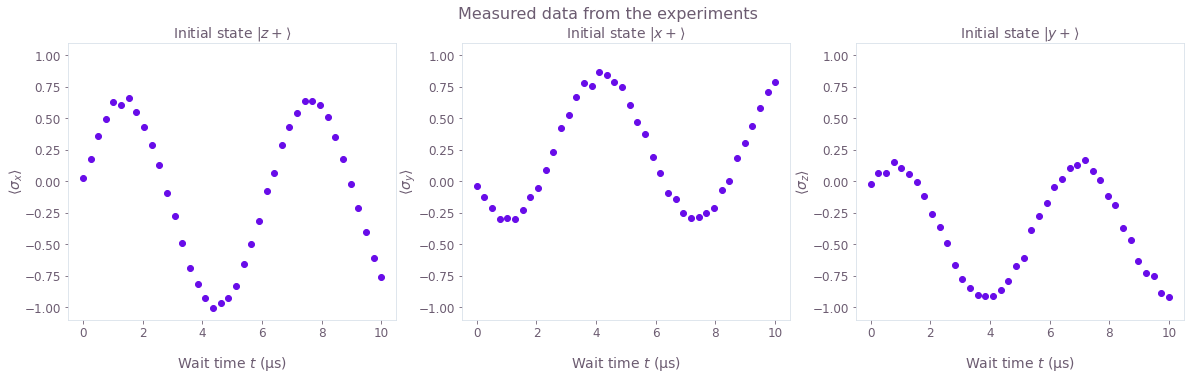

In [4]:
fig, axes = plt.subplots(1, len(black_box_data), figsize=(20, 5))
fig.suptitle("Measured data from the experiments")

for index, axis in enumerate(axes):
    axis.set_title(f"Initial state {initial_states_names[index]}")
    axis.set_ylabel(observables_names[index], labelpad=0)
    axis.plot(wait_times * 1e6, black_box_data[index], "o")
    axis.set_ylim(-1.1, 1.1)
    axis.set_xlabel("Wait time $t$ (µs)")

### 3. Define your model and obtain estimates of the parameters

The next step will be to create a graph that models the system.
This graph will have optimization variables for the parameters that you want to determine.
When you run an optimization on it, it will attempt to minimize the difference between the experimental data and your model, which will allow you to obtain good estimates for the parameters. You can learn more about graphs from our [Understanding graphs in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal) topic and [Get familiar with graphs](https://docs.q-ctrl.com/boulder-opal/tutorials/get-familiar-with-graphs) tutorial.

#### Create the graph object

Start by creating the graph object that will define the calculation.
You can do this by creating a `boulderopal.Graph` instance.

In [5]:
graph = bo.Graph()

#### Create optimizable variables

The next step is to define optimizable variables for the parameters that you want to estimate: $\Omega_x$, $\Omega_y$, and $\Omega_z$.
You can do this using the node `graph.optimization_variable`, which takes a `count` parameter (which you can use to create a batch of variables at the same time) and an `upper_bound` and a `lower_bound`.
In this case, assume that you know that the norm of the variables will be smaller than 1 MHz.

In [6]:
omega_fit = graph.optimization_variable(
    count=3, lower_bound=-1e6, upper_bound=1e6, name="omega_fit"
)
omega_x_fit = omega_fit[0]
omega_y_fit = omega_fit[1]
omega_z_fit = omega_fit[2]

#### Construct the Hamiltonian for the model

Now that you have defined the variables that you want to determine, the next step will be to use them to build a model whose predictions you can compare with the data from the black box.
In this case, the model will contain the following Hamiltonian:
$$ H = \frac{1}{2} \left( \Omega_x \sigma_x + \Omega_y \sigma_y + \Omega_z \sigma_z \right). $$
As this Hamiltonian doesn't change in time, you can define it using the operation `graph.constant_pwc`.

In [7]:
# Define Hamiltonian of the model.
hamiltonian = graph.constant_pwc(
    constant=0.5
    * (omega_x_fit * sigma_x + omega_y_fit * sigma_y + omega_z_fit * sigma_z),
    duration=duration,
)

#### Define the experiments for the model

You will compare the predictions from this model with the data provided to you by the black box.
Do this by setting up in the model the same kind of experiments that you ran in the black box: prepare them in the same initial state, evolve them for the same wait times, and then measure the same observables.

The operation `graph.time_evolution_operators_pwc` allows you to calculate the unitary time evolution operators for the modeled system.
Use it to evolve the system from an initial state up to a certain set of sample times.
Then, use the operations `graph.conjugate`, `graph.transpose`, and matrix products (`@`) to calculate the final expectation value.

The results are organized in a batch of shape `(3, 40)`, where the first dimension represents the three experiment setups, and the second dimension represents all the wait times.
To learn more about batching, see the topic [Batching and broadcasting in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/batching-and-broadcasting-in-boulder-opal).

In [8]:
# Calculate the evolution according to the Hamiltonian.
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=wait_times
)

# Obtain expectation values at the requested times.
final_states = unitaries @ initial_states[:, None]

# Obtain expectation values.
expectation_values = graph.real(
    graph.expectation_value(final_states[..., 0], observables[:, None]),
    name="expectation_values",
)

#### Construct the cost of the optimization

Finally, you can define the cost that you want to minimize as the sum of the square differences between the predictions of your model and your experimental data, known as the [residual sum of squares (RSS)](https://en.wikipedia.org/wiki/Residual_sum_of_squares).
In other words, if $\{ x_i \}$ is the set of input data and $\{ \tilde x_i \}$ are the corresponding predictions from your model, the cost $C_\textrm{RSS}$ will be:

$$ C_\text{RSS} = \sum_i \left( x_i - \tilde x_i \right)^2. $$

Note that for a Gaussian probability of errors with constant standard deviation the RSS is proportional to the negative log likelihood, as described in the topic [Characterizing your hardware using system identification in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/characterizing-your-hardware-using-system-identification-in-boulder-opal).
In a situation like this, minimizing either the RSS or the negative log likelihood is equivalent.

You can calculate this sum using the operations `graph.sum` on the [batches](https://docs.q-ctrl.com/boulder-opal/topics/batching-and-broadcasting-in-boulder-opal) of data from the model and the experiment (`run_experiments`).
In the ideal case where the model and the actual system match perfectly, this cost will be zero.

In [9]:
# Obtain the residual sum of squares (RSS), to be used as cost.
residuals = expectation_values - black_box_data
rss = graph.sum(residuals**2, name="rss")

# Obtain the Hessian, to be used for statistical analysis later.
fit_parameters = [omega_x_fit, omega_y_fit, omega_z_fit]
hessian = graph.hessian(rss, fit_parameters, name="hessian")

### 4. Optimize the graph

Now that the graph is ready, you can run the optimization with the function `boulderopal.run_optimization`.
It will attempt to minimize the node whose `cost_node_name` you provide (in this case, the sum of the square of the differences between the model predictions and the input data).

In [10]:
result = bo.run_optimization(
    graph=graph,
    cost_node_name="rss",
    output_node_names=["expectation_values", "omega_fit", "hessian"],
)

Your task (action_id="1828687") is queued.
Your task (action_id="1828687") has started.
Your task (action_id="1828687") has completed.


### 5. Analyze the results
#### Compare parameters

After the graph optimization has completed, all of the output data is stored in the dictionary returned by `boulderopal.run_optimization`.
The values of the nodes that you have requested when optimizing the graph are stored in the dictionary `result["output"]`.

You can access the `"omega_fit"` key of this object to extract the estimated parameters that you obtained.
As our experiment is simulated by the `run_experiments` function, you can directly compare the estimates with the correct values.

In [11]:
fit_values = result["output"]["omega_fit"]["value"]

print("\t Estimated value\t Correct value")
for name, fit, actual_value in zip(parameter_names, fit_values, actual_parameters):
    print(f"{name}: \t {fit/1e6:.3f} MHz \t\t {actual_value/1e6:.3f} MHz")

	 Estimated value	 Correct value
Ω_x: 	 0.353 MHz 		 0.354 MHz
Ω_y: 	 0.792 MHz 		 0.791 MHz
Ω_z: 	 -0.500 MHz 		 -0.500 MHz


#### Compare the expectation values

The result output also carries the `expectation_values` that you requested during the optimization.
You can plot them together with the expectation values obtained from the experiment, to see how close they are.

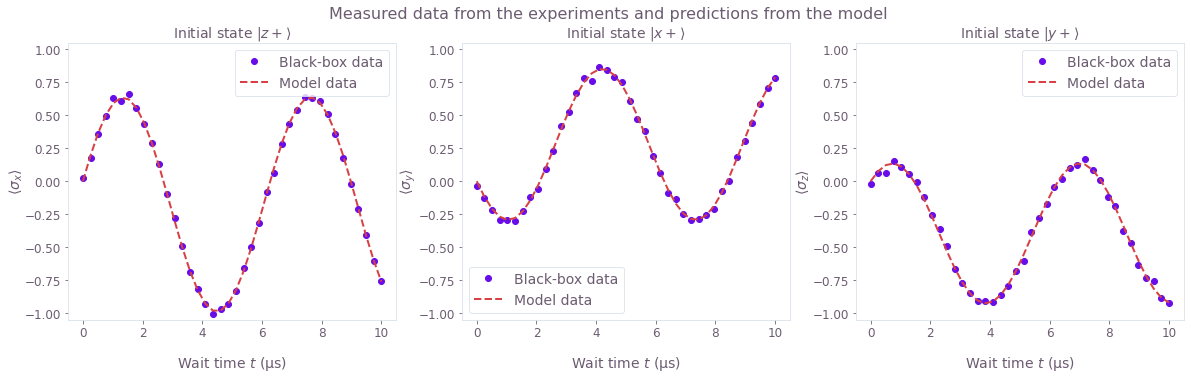

In [12]:
model_data = result["output"]["expectation_values"]["value"]

fig, axes = plt.subplots(1, len(model_data), figsize=(20, 5))

fig.suptitle("Measured data from the experiments and predictions from the model")

for index, axis in enumerate(axes):
    axis.set_title(f"Initial state {initial_states_names[index]}")
    axis.set_ylabel(observables_names[index], labelpad=0)
    axis.plot(wait_times * 1e6, black_box_data[index], "o", label="Black-box data")
    axis.plot(wait_times * 1e6, model_data[index], "--", label="Model data")
    axis.set_ylim(-1.05, 1.05)
    axis.legend()
    axis.set_xlabel("Wait time $t$ (µs)")

#### Estimate accuracy of the results

Now that you have the estimates, you can use some statistical analysis to determine their accuracy.
Following the topic [Characterizing your hardware using system identification in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/characterizing-your-hardware-using-system-identification-in-boulder-opal), you can use the covariance matrix (which for a Gaussian probability distribution is proportional to the inverse of the Hessian matrix) to obtain the confidence region of your estimated parameters.

You can easily calculate and represent a hyperellipse representing the confidence region by using the Q-CTRL Visualizer.
Passing the Hessian, the RSS cost, and number of measurements to [`qctrlvisualizer.confidence_ellipse_matrix`](https://docs.q-ctrl.com/references/qctrl-visualizer/qctrlvisualizer/confidence_ellipse_matrix) will give you a representation the confidence region as a hyperellipse that you can visualize with [`qctrlvisualizer.plot_confidence_ellipses`](https://docs.q-ctrl.com/references/qctrl-visualizer/qctrlvisualizer/plot_confidence_ellipses).

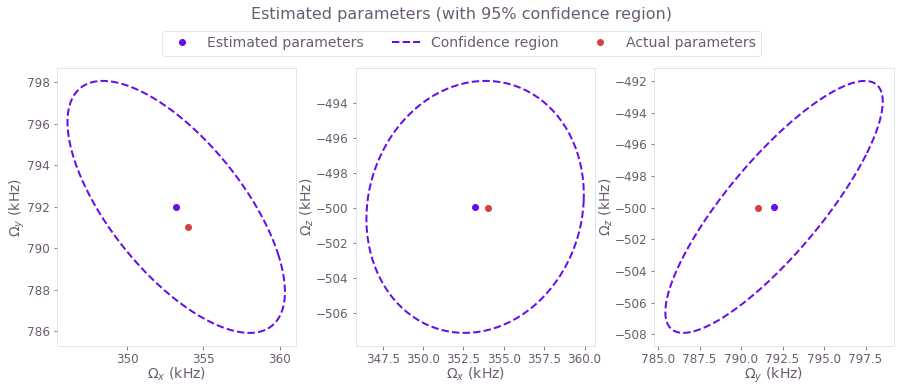

In [13]:
# Plot 95%-confidence ellipses.
confidence_region = qctrlvisualizer.confidence_ellipse_matrix(
    hessian=result["output"]["hessian"]["value"],
    cost=result["cost"],
    measurement_count=3 * len(wait_times),
    confidence_fraction=0.95,
)

qctrlvisualizer.plot_confidence_ellipses(
    confidence_region,
    estimated_parameters=fit_values,
    actual_parameters=actual_parameters,
    parameter_names=[r"$\Omega_x$", r"$\Omega_y$", r"$\Omega_z$"],
)
plt.suptitle("Estimated parameters (with 95% confidence region)", y=1.05)

plt.show()

Congratulations!
You have performed system identification for a single-qubit system.

Our user guides offer more examples and problems to which you can apply system identification.
In particular, you might be interested in reading about [performing Hamiltonian parameter estimation for large amounts of data using stochastic optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-perform-parameter-estimation-with-a-large-amount-of-data) or [using system identification to characterize the bandwidth of a control line](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-characterize-a-transmission-line-using-a-qubit-as-a-probe).

If you want to learn more about Boulder Opal and its capabilities, visit our [topics page](https://docs.q-ctrl.com/boulder-opal/topics), which includes a topic about [system identification](https://docs.q-ctrl.com/boulder-opal/topics/characterizing-your-hardware-using-system-identification-in-boulder-opal).